# Car Company APR Conversions A/B Test

###### by Sam Brady 

### Import Data and Libraries

In [28]:
pip install pandas_profiling

  Using cached MarkupSafe-2.0.1-cp39-cp39-macosx_10_9_x86_64.whl (13 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 1.1.1
    Uninstalling MarkupSafe-1.1.1:
      Successfully uninstalled MarkupSafe-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.1 requires ruamel-yaml, which is not installed.
cookiecutter 1.7.2 requires MarkupSafe<2.0.0, but you have markupsafe 2.0.1 which is incompatible.
abracadabra 0.0.7 requires markupsafe==1.1.1; python_version >= "2.7" and python_version not in "3.0, 3.1, 3.2, 3.3", but you have markupsafe 2.0.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [29]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from scipy import stats
from scipy.stats import chi2_contingency, chisquare, shapiro
from statsmodels.stats.proportion import proportion_confint, confint_proportions_2indep
from statsmodels.stats.power import TTestIndPower


In [30]:
car_company = pd.read_csv('car_company_apr_data.csv', header=0, index_col=False, usecols=list(range(0, 7, 1)))

In [31]:
car_company

,app_id,fico,apr_test_group,apr,converted to sale,vehicle margin,finance margin
0,1,700,control,4.0%,False,NaN,NaN
1,2,700,test,3.0%,False,NaN,NaN
2,3,700,test,3.0%,False,NaN,NaN
3,4,700,control,4.0%,False,NaN,NaN
4,5,700,control,4.0%,True,1000.0,600.0
...,...,...,...,...,...,...,...
19995,19996,600,test,4.4%,True,1000.0,400.0
19996,19997,600,test,4.4%,False,NaN,NaN
19997,19998,600,test,4.4%,False,NaN,NaN
19998,19999,600,control,5.4%,False,NaN,NaN


### EDA

In [32]:
car_company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   app_id             20000 non-null  int64  
 1   fico               20000 non-null  int64  
 2   apr_test_group     20000 non-null  object 
 3   apr                20000 non-null  object 
 4   converted to sale  20000 non-null  bool   
 5   vehicle margin     5021 non-null   float64
 6   finance margin     5021 non-null   float64
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 957.2+ KB


In [33]:
car_company.dtypes

app_id                 int64
fico                   int64
apr_test_group        object
apr                   object
converted to sale       bool
vehicle margin       float64
finance margin       float64
dtype: object

In [34]:
car_company.isna().sum()

app_id                   0
fico                     0
apr_test_group           0
apr                      0
converted to sale        0
vehicle margin       14979
finance margin       14979
dtype: int64

In [35]:
pd.set_option('precision', 4)
car_company.describe()

,app_id,fico,vehicle margin,finance margin
count,20000.000,20000.0000,5021.0,5021.0000
mean,10000.500,649.9950,1000.0,488.7771
std,5773.647,50.0012,0.0,127.3700
min,1.000,600.0000,1000.0,350.0000
25%,5000.750,600.0000,1000.0,350.0000
50%,10000.500,600.0000,1000.0,400.0000
75%,15000.250,700.0000,1000.0,600.0000
max,20000.000,700.0000,1000.0,650.0000


In [36]:
car_company.describe(include=[object])

,apr_test_group,apr
count,20000,20000
unique,2,4
top,control,5.4%
freq,10021,5095


In [37]:
profile = ProfileReport(car_company, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Chart Controls

In [38]:
# set the color theme and chart controls for plotting
# car_company color scheme
car_company_blue = '#00A2D3'
car_company_lightblue = '#47B7DC'
car_company_gold = '#F9B732'
car_company_lightgrey = '#5E5E5E'
car_company_grey = '#343C3A'
car_company_test_palette = {'control':car_company_lightblue, 'test':car_company_gold}
car_company_fico_palette = {600:car_company_lightblue, 700:car_company_gold}
car_company_apr_palette = {3.0:car_company_gold, 4.0:car_company_lightblue, 4.4:car_company_gold, 5.4:car_company_lightblue, 
                       6.4:car_company_lightgrey , 5.0:car_company_lightgrey }
car_company_proj_palette = {0:car_company_gold, 1:car_company_lightblue, 3:car_company_gold, 4:car_company_lightblue, 
                       5:car_company_lightgrey , 2:car_company_lightgrey }
car_company_heatmap = [car_company_blue, car_company_lightblue, car_company_gold, car_company_lightgrey ]
car_company_list = ['#47B7DC','#F9B732', '#47B7DC','#F9B732' , '#47B7DC','#F9B732'  ]
outer_list = [ '#00A2D3','#47B7DC',]
inner_list = ['#F9B732' , '#5E5E5E', '#F9B732','#5E5E5E']

for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = car_company_lightgrey  

# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False


### Data Subsetting and Feature Engineering

In [39]:
# convert apr to float values and remove %
car_company['apr'] = car_company['apr'].str.rstrip('%').astype('float')

In [40]:
# add in total margin column
car_company['total_margin'] = car_company['vehicle margin'] + car_company['finance margin'] 

In [41]:
# group and subset counts of apps and sales
fico_apr = car_company.groupby(['apr_test_group', 'fico', 'apr']).count()
fico_apr = pd.DataFrame(fico_apr.to_records())
fico_apr = fico_apr.rename(columns={'app_id':'total_apps', 'vehicle margin':'num_sales'})
fico_apr = fico_apr.drop(['converted to sale', 'finance margin', 'total_margin'], axis = 1)
fico_apr['num_no_sale'] = fico_apr['total_apps'] - fico_apr['num_sales'] 
fico_apr

,apr_test_group,fico,apr,total_apps,num_sales,num_no_sale
0,control,600,5.4,5095,1044,4051
1,control,700,4.0,4926,1300,3626
2,test,600,4.4,4906,1172,3734
3,test,700,3.0,5073,1505,3568


In [42]:
# group and subset totals of margins, add in per sale
summary_margin = car_company.groupby(['apr_test_group', 'fico', 'apr']).sum()
summary_margin = pd.DataFrame(summary_margin.to_records())
summary_margin = summary_margin.rename(columns={'converted to sale':'num_sales'})
summary_margin = summary_margin.drop(['app_id'], axis = 1)
summary_margin['total_margin_per_sale'] = summary_margin['total_margin'] / summary_margin['num_sales']
summary_margin['vehicle_margin_per_sale'] = summary_margin['vehicle margin'] / summary_margin['num_sales']
summary_margin['finance_margin_per_sale'] = summary_margin['finance margin'] / summary_margin['num_sales']
summary_margin

,apr_test_group,fico,apr,num_sales,vehicle margin,finance margin,total_margin,total_margin_per_sale,vehicle_margin_per_sale,finance_margin_per_sale
0,control,600,5.4,1044,1044000.0,678600.0,1722600.0,1650.0,1000.0,650.0
1,control,700,4.0,1300,1300000.0,780000.0,2080000.0,1600.0,1000.0,600.0
2,test,600,4.4,1172,1172000.0,468800.0,1640800.0,1400.0,1000.0,400.0
3,test,700,3.0,1505,1505000.0,526750.0,2031750.0,1350.0,1000.0,350.0


In [43]:
# add in conversion rate per group
conversion = car_company.groupby(['apr_test_group', 'fico', 'apr']).agg([np.mean, np.std]).drop(['app_id', 
                            'vehicle margin', 'finance margin', 'total_margin'], axis = 1)
conversion = pd.DataFrame(conversion.to_records())
conversion.columns = ['apr_test_group', 'fico', 'apr', 'conversion_rate', 'conversion_std']
conversion

,apr_test_group,fico,apr,conversion_rate,conversion_std
0,control,600,5.4,0.2049,0.4037
1,control,700,4.0,0.2639,0.4408
2,test,600,4.4,0.2389,0.4264
3,test,700,3.0,0.2967,0.4568


In [44]:
# combine all subsets into a summary df, add in margins per app
summary = fico_apr.merge(summary_margin, how='inner', on=['apr_test_group', 'fico', 'apr', 'num_sales'])
summary = conversion.merge(summary, how='inner', on=['apr_test_group', 'fico', 'apr'])
summary['total_margin_per_app'] =  summary['total_margin'] / summary['total_apps'] 
summary['vehicle_margin_per_app'] =  summary['vehicle margin'] / summary['total_apps'] 
summary['finance_margin_per_app'] =  summary['finance margin'] / summary['total_apps'] 
summary

,apr_test_group,fico,apr,conversion_rate,conversion_std,total_apps,num_sales,num_no_sale,vehicle margin,finance margin,total_margin,total_margin_per_sale,vehicle_margin_per_sale,finance_margin_per_sale,total_margin_per_app,vehicle_margin_per_app,finance_margin_per_app
0,control,600,5.4,0.2049,0.4037,5095,1044,4051,1044000.0,678600.0,1722600.0,1650.0,1000.0,650.0,338.0962,204.9068,133.1894
1,control,700,4.0,0.2639,0.4408,4926,1300,3626,1300000.0,780000.0,2080000.0,1600.0,1000.0,600.0,422.2493,263.9058,158.3435
2,test,600,4.4,0.2389,0.4264,4906,1172,3734,1172000.0,468800.0,1640800.0,1400.0,1000.0,400.0,334.4476,238.8912,95.5565
3,test,700,3.0,0.2967,0.4568,5073,1505,3568,1505000.0,526750.0,2031750.0,1350.0,1000.0,350.0,400.5027,296.6686,103.8340


In [45]:
metrics = summary[['apr_test_group', 'fico', 'apr', 'num_sales', 'conversion_rate','total_margin', 'total_margin_per_app']]
metrics

,apr_test_group,fico,apr,num_sales,conversion_rate,total_margin,total_margin_per_app
0,control,600,5.4,1044,0.2049,1722600.0,338.0962
1,control,700,4.0,1300,0.2639,2080000.0,422.2493
2,test,600,4.4,1172,0.2389,1640800.0,334.4476
3,test,700,3.0,1505,0.2967,2031750.0,400.5027


In [46]:
# subset df by A/B group
ab_test = car_company.groupby(['apr_test_group']).agg([np.mean, np.std, np.sum, 'count'])
ab_test = pd.DataFrame(ab_test.to_records())
ab_test = ab_test.drop(columns = ab_test.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18, 20, 21, 22, 
                                                  24, 25, 26, 28]])
ab_test.columns = ['apr_test_group', 'conversion_rate', 'conversion_std', 'num_sales', 'total_apps',
                   'total_vehichle_margin', 'total_finance_margin', 'total_margin']
ab_test['total_margin_per_app'] = ab_test['total_margin']/ab_test['total_apps']
ab_test

,apr_test_group,conversion_rate,conversion_std,num_sales,total_apps,total_vehichle_margin,total_finance_margin,total_margin,total_margin_per_app
0,control,0.2339,0.4233,2344,10021,2344000.0,1458600.0,3802600.0,379.4631
1,test,0.2683,0.4431,2677,9979,2677000.0,995550.0,3672550.0,368.0279


##### Quick Sanity Checks!

In [47]:
# double check some random values
print((summary.iloc[0]['vehicle_margin_per_sale'] + summary.iloc[0]['finance_margin_per_sale']) * summary.iloc[0]['num_sales'] == summary.iloc[0]['total_margin'])
print((summary.iloc[3]['finance_margin_per_app'] + summary.iloc[3]['vehicle_margin_per_app']) * summary.iloc[3]['total_apps'] == summary.iloc[3]['total_margin'])

True
True


# 😁

### Feature Heatmap

In [48]:
hmap = car_company[['apr_test_group','fico','apr', 'converted to sale', 'vehicle margin','finance margin', 
                'total_margin']].fillna(0).copy()
hmap['apr_test_group'] = hmap['apr_test_group'].map({'control':0, 'test':1})


In [49]:
# Use a pearson correlation to measure the relationship between features

pd.set_option('display.width', 100)
pd.set_option('precision', 8)

hmap = hmap.corr(method='pearson')

display(hmap)

,apr_test_group,fico,apr,converted to sale,vehicle margin,finance margin,total_margin
apr_test_group,1.00000000,0.01679983,-0.59023649,0.03961384,0.03961384,-0.10343743,-0.00881389
fico,0.01679983,1.00000000,-0.81703233,0.06797494,0.06797494,0.03605206,0.05773786
apr,-0.59023649,-0.81703233,1.00000000,-0.07772342,-0.07772342,0.03054318,-0.04153160
converted to sale,0.03961384,0.06797494,-0.07772342,1.00000000,1.00000000,0.95754031,0.99515005
vehicle margin,0.03961384,0.06797494,-0.07772342,1.00000000,1.00000000,0.95754031,0.99515005
finance margin,-0.10343743,0.03605206,0.03054318,0.95754031,0.95754031,1.00000000,0.98125589
total_margin,-0.00881389,0.05773786,-0.04153160,0.99515005,0.99515005,0.98125589,1.00000000


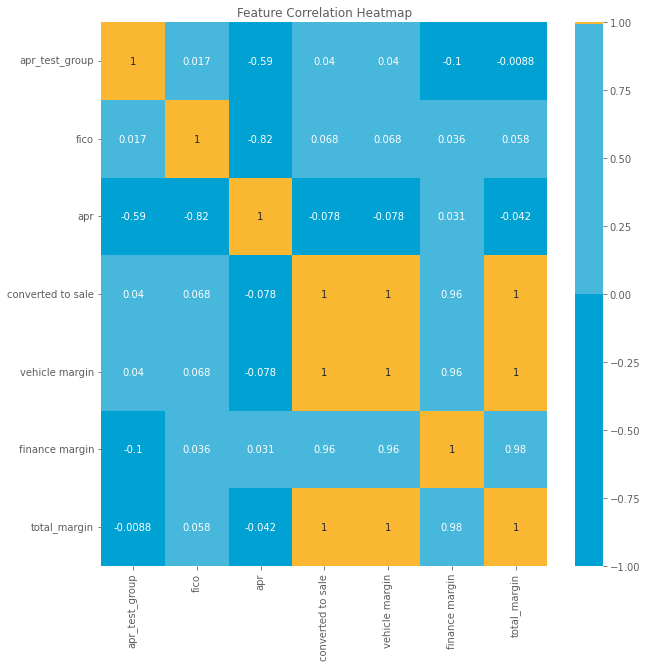

In [50]:
# heatmap of the correlation to visualize the relationships between features
plt.figure(figsize=(10,10))
plt.title('Feature Correlation Heatmap')
cmap = sns.color_palette(car_company_heatmap, 4)
sns.heatmap(hmap, annot = True, vmin=-1, vmax=1, cmap=cmap, center=1)

plt.show()

## A/B Test

#### Structure
>######  The two randomized tests have been structured to test a drop in APR for both 600 and 700 FICO score bucket groups to see if it would increase conversion. 
>###### 
>######  FICO scores of 600 have a 1.4 point higher APR than FICO scores of 700, each will be tested by lowering the APR by 1.0 point.
#### Metrics
>######  Our Success Metric will be the Conversion Rate. 
>######  Our Guardrail Metric will be the Total Margin per App. 
>######  Finance Margin per App and Vehicle Margin per App will also be monitored. 
#### Minimum Detectable Effect (MDE), Alpha, and Power
>######  After consulting with the business leaders and looking at historical data from past tests a MDE of 0.06 was chosen for this test (the difference between the two groups scaled by the standard deviation needs to be at least 0.06). 
>######  Also they decided on using a standard 0.05 alpha value and 0.8 power value.
#### Verifying Sample Size and No Sample Ratio Mismatch
>######  Using the above values, it was calculated that the minimum sample size would need to be at least 4357 per test subgroup. And there was probably no Sample Ratio Mismatch between the control and test groups. 
#### Timing
>######  With that knowledege and looking at our average daily users it was approximated that this test would take 12 days to run, accounting for seasonality. 
#### Hypothesis - The Success Metric
>######  The business is hoping that buy lowering the APR 1.0 point for customers that they will see an increase in their conversions. 
>######  Our Null Hypothesis will then be that lowering APR by 1.0 point will not have an effect on conversions. 
>######  And our Alternative Hypothesis will be that lowering the APR by 1.0 point will have some effect on conversions.
#### Hypothesis - The Guardrail Metric
>######  To make sure an increase in conversions doesn't have the undesired effect of the business losing money, we will also monitor the Total Margin per App as a guardrail metric.
#### Bonferroni Correction
>######  Since I will be running two statistical tests on the same set of sample data, I will use the Bonferroni correction to adjust my alpha values in the hopes of minimizing any type 1 errors. 

### Data Subsetting 

In [51]:
# subset df
control = car_company[car_company['apr_test_group'] == 'control']
test = car_company[car_company['apr_test_group'] == 'test']

control_600 = control[control['fico']== 600]
control_700 = control[control['fico']== 700]
test_600 = test[test['fico']== 600]
test_700 = test[test['fico']== 700]

control_600_conv = control_600['converted to sale'].astype(int)
control_700_conv = control_700['converted to sale'].astype(int)
test_600_conv = test_600['converted to sale'].astype(int)
test_700_conv = test_700['converted to sale'].astype(int)

control_600_mpa = control_600['total_margin'].fillna(0)
control_700_mpa = control_700['total_margin'].fillna(0)
test_600_mpa = test_600['total_margin'].fillna(0)
test_700_mpa = test_700['total_margin'].fillna(0)

### Bonferroni Correction

In [52]:
# since I plan to run two statistical tests, I will adjust for the faimly-wise error

# original alpha
alpha = 0.05
# the number of tests
m = 2

corrected_alpha = alpha / m

interval_percentage = round((1 - corrected_alpha) * 100, 2)

print(f"The new alpha corrected for multiple tests is {corrected_alpha:.8f}")
print(f"And this will calculate {interval_percentage}% confidence intervals")

The new alpha corrected for multiple tests is 0.02500000
And this will calculate 97.5% confidence intervals


### Distributions

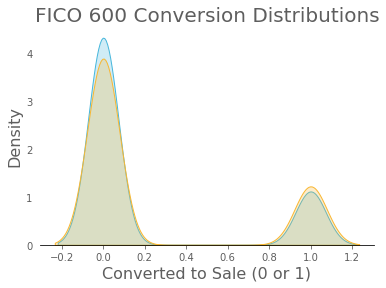

In [53]:
# compare distributions of conversions for 600 fico
sns.kdeplot(control_600_conv, label='control', shade = True, color = car_company_lightblue )
sns.kdeplot(test_600_conv, label='test', shade = True, color = car_company_gold)
plt.title('FICO 600 Conversion Distributions', fontsize = 20)
plt.xlabel('Converted to Sale (0 or 1)', fontsize=16);
plt.ylabel('Density', fontsize=16)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)
plt.show()

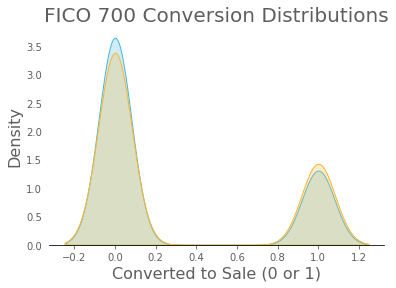

In [54]:
# compare distributions of conversions for 700 fico
sns.kdeplot(control_700_conv, label='control', shade = True, color = car_company_lightblue )
sns.kdeplot(test_700_conv, label='test', shade = True, color = car_company_gold)
plt.title('FICO 700 Conversion Distributions', fontsize = 20)
plt.xlabel('Converted to Sale (0 or 1)', fontsize=16);
plt.ylabel('Density', fontsize=16)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)
plt.show()

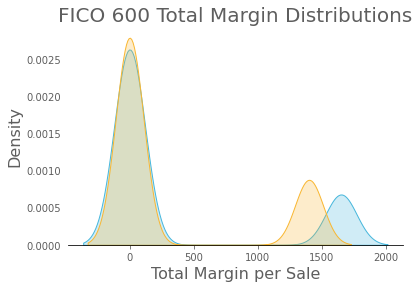

In [55]:
# compare distributions of total margin fico 600 
sns.kdeplot(control_600_mpa , label='control', shade = True, 
            color = car_company_lightblue )
sns.kdeplot(test_600_mpa , label='test', shade = True, 
            color = car_company_gold )
plt.title('FICO 600 Total Margin Distributions', fontsize = 20)
plt.xlabel('Total Margin per Sale', fontsize=16);
plt.ylabel('Density', fontsize=16)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)
plt.show()

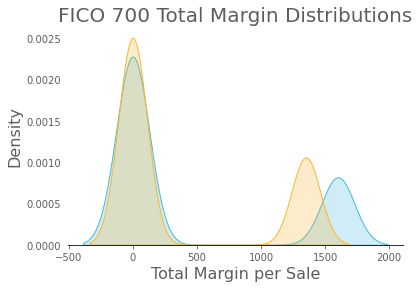

In [56]:
# compare distributions of total margin fico 700 
sns.kdeplot(control_700_mpa , label='control', shade = True, 
            color = car_company_lightblue )
sns.kdeplot(test_700_mpa , label='test', shade = True, 
            color = car_company_gold )
plt.title('FICO 700 Total Margin Distributions', fontsize = 20)
plt.xlabel('Total Margin per Sale', fontsize=16);
plt.ylabel('Density', fontsize=16)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)
plt.show()

### Verifying Sample Size

In [57]:
nobs1 = len(control_600)
nobs2 = len(test_600)
ratio = nobs2 / nobs1

effect = 0.065
alpha = corrected_alpha
power = 0.8

# perform power analysis 
analysis = TTestIndPower()
result = analysis.solve_power(effect, nobs1=None, power = power, ratio = ratio, alpha = alpha)
print(f'Minimum Sample Size: {round(result)} per group')

Minimum Sample Size: 4587 per group


In [58]:
nobs1 = len(control_700)
nobs2 = len(test_700)
ratio = nobs2 / nobs1

effect = 0.065
alpha = corrected_alpha
power = 0.8

# perform power analysis 
analysis = TTestIndPower()
result = analysis.solve_power(effect, nobs1=None, power = power, ratio = ratio, alpha = alpha)
print(f'Minimum Sample Size: {round(result)} per group')

Minimum Sample Size: 4435 per group


### Checking Sample Ratio Mismatch

In [59]:
nobs1 = len(control_600)
nobs2 = len(test_600)
ratio = nobs2 / nobs1

observed = [nobs1, nobs2]
total_traffic= sum(observed)
expected = [ total_traffic/2, total_traffic/2 ]

chi = chisquare(observed, f_exp=expected)

if chi[1] < 0.01:
    print(f'With p-value of {round(chi[1],4)} and chi-squared statistic of {round(chi[0],4)}')
    print('Warning. Sample Ratio Mismatch may be present.')
else:
    print(f'With p-value of {round(chi[1],4)} and chi-squared statistic of {round(chi[0],4)}')
    print('Probably no Sample Ratio Mismatch.\n')

With p-value of 0.0588 and chi-squared statistic of 3.5717
Probably no Sample Ratio Mismatch.



In [60]:
nobs1 = len(control_700)
nobs2 = len(test_700)
ratio = nobs2 / nobs1

observed = [ nobs1, nobs2 ]
total_traffic= sum(observed)
expected = [ total_traffic/2, total_traffic/2 ]

chi = chisquare(observed, f_exp=expected)

if chi[1] < 0.01:
    print(f'With p-value of {round(chi[1],4)} and chi-squared statistic of {round(chi[0],4)}')
    print('Warning. Sample Ratio Mismatch may be present.')
else:
    print(f'With p-value of {round(chi[1],4)} and chi-squared statistic of {round(chi[0],4)}')
    print('Probably no Sample Ratio Mismatch.\n')

With p-value of 0.1415 and chi-squared statistic of 2.1611
Probably no Sample Ratio Mismatch.



### Success Metric Hypothesis Tests
##### Chi Squared Test

##### Null Hypothesis - H0: There is no relationship between the variables. 
>###### (Lowering the APR by 1.0 point will not effect Conversions)
##### Alternative Hypothesis - H1: There is a signifigant relationship between the variables. 
>######  (Lowering the APR by 1.0 point will effect Conversions)

In [61]:
a_conv_600 = control_600_conv.sum()
a_no_conv_600 = control_600_conv.size - control_600_conv.sum()
b_conv_600 = test_600_conv.sum()
b_no_conv_600 = test_600_conv.size - test_600_conv.sum()

# create an array
T = np.array([[a_conv_600, a_no_conv_600], [b_conv_600, b_no_conv_600]])

In [62]:
# chi2 test
chi2, p_val , dof, exp= chi2_contingency(T, correction=False)

print(f'chi2-statistic :  {chi2:.4f}')
print(f'p-value :   {p_val:.8f}')
print('\n')
if p_val < corrected_alpha:
      print("Reject the null hypothesis. Dependent, there is a signifigant relationship between the variables.")
else:
      print("Fail to reject the null hypothesis. Independent, there is no relationship between the variables.")    

chi2-statistic :  16.7358
p-value :   0.00004296


Reject the null hypothesis. Dependent, there is a signifigant relationship between the variables.


In [63]:
a_conv_700 = control_700_conv.sum()
a_no_conv_700 = control_700_conv.size - control_700_conv.sum()
b_conv_700 = test_700_conv.sum()
b_no_conv_700 = test_700_conv.size - test_700_conv.sum()

# create an array
T = np.array([[a_conv_700, a_no_conv_700], [b_conv_700, b_no_conv_700]])

In [64]:
chi2, p_val , dof, exp= chi2_contingency(T, correction=False)

print(f'chi2-statistic :  {chi2:.4f}')
print(f'p-value :   {p_val:.8f}')
print('\n')
if p_val < corrected_alpha:
      print("Reject the null hypothesis. Dependent, there is a signifigant relationship between the variables.")
else:
      print("Fail to reject the null hypothesis. Independent, there is no relationship between the variables.")   

chi2-statistic :  13.2915
p-value :   0.00026661


Reject the null hypothesis. Dependent, there is a signifigant relationship between the variables.


### Success Metric Confidence Intervals

In [75]:
# subset df
nobs_control = len(control_600_conv)
nobs_test = len(test_600_conv)

In [76]:
lower, upper = confint_proportions_2indep(test_600_conv.sum(), nobs_test, 
                                            control_600_conv.sum(), nobs_control, 
                                                        compare='diff', alpha=corrected_alpha)

print(f'{interval_percentage}% Confidence Interval for Difference in Means Test Group 600: [{round(lower*100,2)}%, {round(upper*100,2)}%]')


97.5% Confidence Interval for Difference in Means Test Group 600: [1.54%, 5.26%]


In [77]:

# find confidence intervals for conversion rates per test group 600

lower_test, upper_test = proportion_confint(count=np.sum(test_600_conv),
                                                                nobs=nobs_test, alpha=corrected_alpha)

test_conversion_rate = np.mean(test_600_conv)

print(f'{interval_percentage}% Confidence Interval for Test Group 600 Conversion Rate: [{round(lower_test*100,2)}%, {round(upper_test*100,2)}%]')
print(f'With a Conversion Rate of {round(test_conversion_rate * 100,2)}% for the Test Group 600')

97.5% Confidence Interval for Test Group 600 Conversion Rate: [22.52%, 25.25%]
With a Conversion Rate of 23.89% for the Test Group 600


In [78]:
# find confidence intervals for conversion rates per control group 600

lower_control, upper_control = proportion_confint(count=np.sum(control_600_conv),
                                                                nobs=nobs_control, alpha=corrected_alpha)

control_conversion_rate = np.mean(control_600_conv)

print(f'{interval_percentage}% Confidence Interval for Control Group 600 Conversion Rate: [{round(lower_control*100,2)}%, {round(upper_control*100,2)}%]')
print(f'With a Conversion Rate of {round(control_conversion_rate * 100,2)}% for the Control Group 600')

97.5% Confidence Interval for Control Group 600 Conversion Rate: [19.22%, 21.76%]
With a Conversion Rate of 20.49% for the Control Group 600


In [79]:
# subset df
nobs_control = len(control_700_conv)
nobs_test = len(test_700_conv)

In [80]:
lower, upper = confint_proportions_2indep(test_700_conv.sum(), nobs_test, 
                                            control_700_conv.sum(), nobs_control, 
                                                        compare='diff', alpha=corrected_alpha)

print(f'{interval_percentage}% Confidence Interval for Difference in Means Test Group 700: [{round(lower*100,2)}%, {round(upper*100,2)}%]')


97.5% Confidence Interval for Difference in Means Test Group 700: [1.26%, 5.29%]


In [165]:

# find confidence intervals for conversion rates per test group 700

lower_test, upper_test = proportion_confint(count=np.sum(test_700_conv),
                                                                nobs=nobs_test, alpha=corrected_alpha)

test_conversion_rate = np.mean(test_700_conv)

print(f'{interval_percentage}% Confidence Interval for Test Group 700 Conversion Rate: [{round(lower_test*100,2)}%, {round(upper_test*100,2)}%]')
print(f'With a Conversion Rate of {round(test_conversion_rate * 100,2)}% for the Test Group 700')

97.5% Confidence Interval for Test Group 700 Conversion Rate: [28.23%, 31.1%]
With a Conversion Rate of 29.67% for the Test Group 700


In [166]:
# find confidence intervals for conversion rates per control group 700

lower_control, upper_control = proportion_confint(count=np.sum(control_700_conv),
                                                                nobs=nobs_control, alpha=corrected_alpha)

control_conversion_rate = np.mean(control_700_conv)

print(f'{interval_percentage}% Confidence Interval for Control Group 700 Conversion Rate: [{round(lower_control*100,2)}%, {round(upper_control*100,2)}%]')
print(f'With a Conversion Rate of {round(control_conversion_rate * 100,2)}% for the Control Group 700')

97.5% Confidence Interval for Control Group 700 Conversion Rate: [24.98%, 27.8%]
With a Conversion Rate of 26.39% for the Control Group 700


0.975

### Guardrail Metric Total Margin per App

In [174]:
#create confidence interval for average total margin 600 

lower_test, upper_test = stats.norm.interval(alpha=1-corrected_alpha, loc=np.mean(test_600_mpa), scale=stats.sem(test_600_mpa))

test_avg_total_margin = np.mean(test_600_mpa)

print(f'{interval_percentage}% Confidence Interval for Test Group 600 Total Margin per App: [{lower_test:.2f}, {upper_test:.2f}]')
print(f'With a Total Margin per App of {round(test_avg_total_margin,2)} for the Test Group 600')

97.5% Confidence Interval for Test Group 600 Total Margin per App: [315.34, 353.55]
With a Total Margin per App of 334.45 for the Test Group 600


In [175]:
#create confidence interval for average total margin 600

lower_test, upper_test = stats.norm.interval(alpha=1-corrected_alpha, loc=np.mean(control_600_mpa), scale=stats.sem(control_600_mpa))

test_avg_total_margin = np.mean(control_600_mpa)

print(f'{interval_percentage}% Confidence Interval for Control Group 600 Total Margin per App: [{lower_test:.2f}, {upper_test:.2f}]')
print(f'With a Total Margin per App of {round(test_avg_total_margin,2)} for the Control Group 600')

97.5% Confidence Interval for Control Group 600 Total Margin per App: [317.18, 359.01]
With a Total Margin per App of 338.1 for the Control Group 600


In [176]:
#create confidence interval for average total margin 700 

lower_test, upper_test = stats.norm.interval(alpha=1-corrected_alpha, loc=np.mean(test_700_mpa), scale=stats.sem(test_700_mpa))

test_avg_total_margin = np.mean(test_700_mpa)

print(f'{interval_percentage}% Confidence Interval for Test Group 700 Total Margin per App: [{lower_test:.2f}, {upper_test:.2f}]')
print(f'With a Total Margin per App of {round(test_avg_total_margin,2)} for the Test Group 700')

97.5% Confidence Interval for Test Group 700 Total Margin per App: [381.09, 419.91]
With a Total Margin per App of 400.5 for the Test Group 700


In [177]:
#create confidence interval for average total margin 700

lower_test, upper_test = stats.norm.interval(alpha=1-corrected_alpha, loc=np.mean(control_700_mpa), scale=stats.sem(control_700_mpa))

test_avg_total_margin = np.mean(control_700_mpa)

print(f'{interval_percentage}% Confidence Interval for Control Group 700 Total Margin per App: [{lower_test:.2f}, {upper_test:.2f}]')
print(f'With a Total Margin per App of {round(test_avg_total_margin,2)} for the Control Group 700')

97.5% Confidence Interval for Control Group 700 Total Margin per App: [399.73, 444.77]
With a Total Margin per App of 422.25 for the Control Group 700


### Effect's Size

##### Cohen's d

In [178]:
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

In [179]:
# calculate cohen's d
d = cohend(test_600_conv, control_600_conv)
print('Cohens d: %.3f' % d)
print('\n')
if d < 0.01:
      print("Very small effect size")
elif d < 0.2:
      print("Small effect size")
elif d < 0.5:
      print("Medium effect size")
elif d < 0.8:
      print("Large effect size")
elif d < 1.2:
      print("Very Large effect size")
else:
    print("Huge effect size")  

Cohens d: 0.082


Small effect size


In [180]:
# calculate cohen's d
d = cohend(test_700_conv, control_700_conv)
print('Cohens d: %.3f' % d)
print('\n')
if d < 0.01:
      print("Very small effect size")
elif d < 0.2:
      print("Small effect size")
elif d < 0.5:
      print("Medium effect size")
elif d < 0.8:
      print("Large effect size")
elif d < 1.2:
      print("Very Large effect size")
else:
    print("Huge effect size")  

Cohens d: 0.073


Small effect size


### Expected Value

In [181]:
p_control_700 = summary[(summary['apr_test_group'] == 'control') & (summary['fico'] == 700)]['conversion_rate']
p_control_600 = summary[(summary['apr_test_group'] == 'control') & (summary['fico'] == 600)]['conversion_rate']
x_control_700 = summary[(summary['apr_test_group'] == 'control') & (summary['fico'] == 700)]['total_margin_per_sale']
x_control_600 = summary[(summary['apr_test_group'] == 'control') & (summary['fico'] == 600)]['total_margin_per_sale']


In [182]:
# expected value of control groups

ev_control = round((p_control_600 * x_control_600).sum() + (p_control_700 * x_control_700).sum(), 2) 
print(f'The Expected Value of the Control Group is {ev_control}')

The Expected Value of the Control Group is 760.35


In [183]:
p_test_700 = metrics[(metrics['apr_test_group'] == 'test') & (metrics['fico'] == 700)]['conversion_rate']
p_test_600 = metrics[(metrics['apr_test_group'] == 'test') & (metrics['fico'] == 600)]['conversion_rate']
x_test_700 = summary[(summary['apr_test_group'] == 'test') & (summary['fico'] == 700)]['total_margin_per_sale']
x_test_600 = summary[(summary['apr_test_group'] == 'test') & (summary['fico'] == 600)]['total_margin_per_sale']

In [184]:
# expected value of test groups

ev_test = round((p_test_600 * x_test_600).sum() + (p_test_700 * x_test_700).sum(), 2) 
print(f'The Expected Value of the Test Group is {ev_test}')

The Expected Value of the Test Group is 734.95


### Summary of A/B Test

##### FICO Score 600 Group
>######  After gathering the appropriate number of samples according to the minimum sample size and then running Chi Squared tests, there was minimal evidence to accept the null hypothesis and thus we can reject that hypothesis for each FICO score subgroup.
>######  With a p-value of approximately 0.00004296, we can say that it is highly unlikely that we would see this difference in conversion rate between groups if the null hypothesis were true.
>######  The conversion rate uplift or difference in conversion rate from test to control group is 3.4 percentage points.
>###### 97.5% Confidence Interval for Test Group Conversion Rate: [22.52%, 25.25%]
>###### With a Conversion Rate of 23.89% for the Test Group
>###### 97.5% Confidence Interval for Control Group 600 Conversion Rate: [19.22%, 21.76%]
>###### With a Conversion Rate of 20.49% for the Control Group 600
>######  Although there was an increase in conversion, the guardrail metric of total margin per app decrease -3.61 dollars. 
##### FICO Score 700 Group
>######  After gathering the appropriate number of samples according to the minimum sample size and then running Chi Squared tests, there was minimal evidence to accept the null hypothesis and thus we can reject that hypothesis for each FICO score subgroup.
>######  With a p-value of approximately  0.00026661, we can say that it is highly unlikely that we would see this difference in conversion rate between groups if the null hypothesis were true.
>######  The conversion rate uplift or difference in conversion rate from test to control group is 3.28 percentage points.
>###### 97.5% Confidence Interval for Test Group 700 Conversion Rate: [28.23%, 31.1%]
>###### With a Conversion Rate of 29.67% for the Test Group 700
>###### 97.5% Confidence Interval for Control Group 700 Conversion Rate: [24.98%, 27.8%]
>###### With a Conversion Rate of 26.39% for the Control Group 700
>######  Although there was an increase in conversion, the guardrail metric of total margin per app decrease -21.75 dollars. 
##### Findings
>###### In general a decrease in APR leads to an increase in conversion rates, however it does not necessarily lead to a decrease of total margin per app.
>###### When you look closer at total margin per app at the FICO group level, you can then see that a decrease in APR does in fact decrease total margin per app at that level.
>###### Although a decrease in APR brought in a higher number of sales and drove up the conversion rates in both FICO buckets, it unfortunately also lead to a decrease in total margin, and thus total margin per app for both groups as well.
>###### Because of the increase in conversion rate there was also an increase of 333 cars sold when comparing test to control groups. 
>###### While there is a slight increase in vehicle margin per app for a decrease in APR, it is far outweighted by the inverse effect on the finance margin.
>###### The expected value of a sale in the control group (760.35) was higher than in the test group (734.95) by 25.40.
>###### For a drop of 1.0 point in APR there is a loss of \$3.65 in total margin per app for the 600 FICO score group. 
>###### For a drop of 1.0 point in APR there is a loss of \$21.75 in total margin per app for the 700 FICO score group. 
>###### Despite the large loss in total margins per app, the 700 bucket had a much smaller loss in total margin overall likely due to the increase in sales and overall higher conversion rates.
>###### Both groups showed that a drop in APR had a small effects size on conversions. 
##### Conclusions
>###### Perhaps it is worth considering trying to increase the vehicle margin per sale in this 700 group to make up for the finance margin, but this might deter the customer who would in turn then be spending more out of pocket.
>###### My recommendation would be then for the buisness leaders to try to renegotiate the vehicle's finance margins with the companies purchasing these car loans toward a higher margin especially for the 700 FICO score group. With an increase in in loans for sale due to the increase in conversions brought in by the new low APR, the buyers might be willing to renegotiate.  
>###### By using expected value, I will demonstrate that if we are able to negotiate a 100 dollar increase in finance margins for both FICO buckets, a lower APR will become sustainable. 
>###### Hopefully then we can re-run this A/B test to see an increase in Total Margin per App as well as Total Conversions. 


### Charts for Executive Summary Slides

In [86]:
# subset df
pricing = summary[['apr_test_group', 'fico', 'apr', 'total_apps', 'num_sales', 'num_no_sale']].copy()
pricing

,apr_test_group,fico,apr,total_apps,num_sales,num_no_sale
0,control,600,5.4,5095,1044,4051
1,control,700,4.0,4926,1300,3626
2,test,600,4.4,4906,1172,3734
3,test,700,3.0,5073,1505,3568


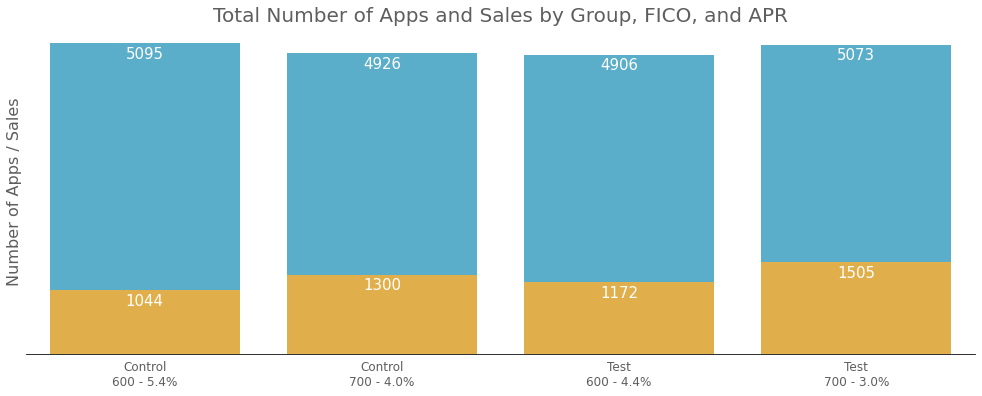

In [87]:
# plot apps and sales for each sub group

plt.figure(figsize=(17,6))

order = [5.4, 4.0, 4.4, 3.0]

apps = sns.barplot(data=pricing, x="apr", y="total_apps", order = order, color = car_company_lightblue)
sales = sns.barplot(data=pricing, x="apr", y="num_sales", order = order, color = car_company_gold)

plt.title("Total Number of Apps and Sales by Group, FICO, and APR", fontsize=20)
plt.xlabel("", fontsize=16)
plt.ylabel("Number of Apps / Sales", fontsize=16)
plt.xticks(ticks = range(4) ,labels = ['Control\n600 - 5.4%', 'Control\n700 - 4.0%', 'Test\n600 - 4.4%',
                                       'Test\n700 - 3.0%' ], size =12)
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=True)

for index, row in pricing[['num_sales']].iterrows():
    sales.text(row.name, row.num_sales-250, row.num_sales, color='white', ha="center", fontsize=15)

for index, row in pricing[['total_apps']].iterrows():
    apps.text(row.name, row.total_apps-250, row.total_apps, color='white', ha="center", fontsize=15)

plt.show()



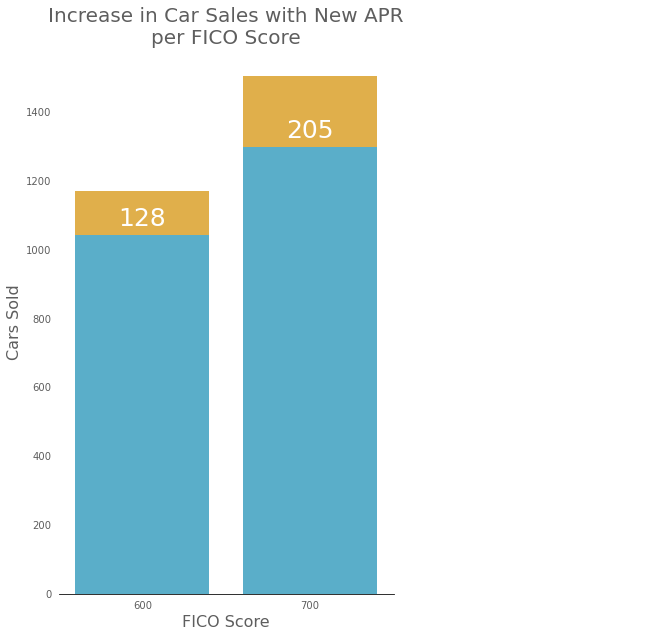

In [88]:
# plot increase in sales
plt.figure(figsize=(6, 10))
  

t_sales = sns.barplot(x=pricing[pricing['apr_test_group'] == 'test']['fico'], 
                      y=pricing[pricing['apr_test_group'] == 'test']['num_sales'], color=car_company_gold)
c_sales = sns.barplot(x=pricing[pricing['apr_test_group'] == 'control']['fico'], 
                      y=pricing[pricing['apr_test_group'] == 'control']['num_sales'], color=car_company_lightblue)
  
plt.title("Increase in Car Sales with New APR\nper FICO Score", fontsize=20)
plt.xlabel("FICO Score", fontsize=16)
plt.ylabel("Cars Sold", fontsize=16)
plt.tick_params(left=False,bottom=False,labelleft=True,labelbottom=True)

row_list = []
for index, row1 in pricing[pricing['apr_test_group'] == 'test'][['num_sales']].iterrows():
    t_sales.text(row1.name, row1.num_sales-50, row1.num_sales, color='white', ha="center", fontsize=15)
    row_list.append(row1[0])

for index, row in pricing[pricing['apr_test_group'] == 'control'][['num_sales']].iterrows():
    c_sales.text(row.name, row.num_sales+25, row_list[index]-row.num_sales, color='white', ha="center", fontsize=25)

plt.show()

In [89]:
# subset df
conversion = summary[['apr_test_group', 'fico', 'apr','conversion_rate', 'conversion_std', 'num_sales']].copy()
conversion

,apr_test_group,fico,apr,conversion_rate,conversion_std,num_sales
0,control,600,5.4,0.20490677,0.40367310,1044
1,control,700,4.0,0.26390581,0.44079357,1300
2,test,600,4.4,0.23889115,0.42644957,1172
3,test,700,3.0,0.29666864,0.45683421,1505


In [90]:
# subset df
group_conversion = ab_test[['apr_test_group','conversion_rate', 'conversion_std', 'num_sales']].copy()
group_conversion

,apr_test_group,conversion_rate,conversion_std,num_sales
0,control,0.23390879,0.42333598,2344
1,test,0.26826335,0.44307765,2677


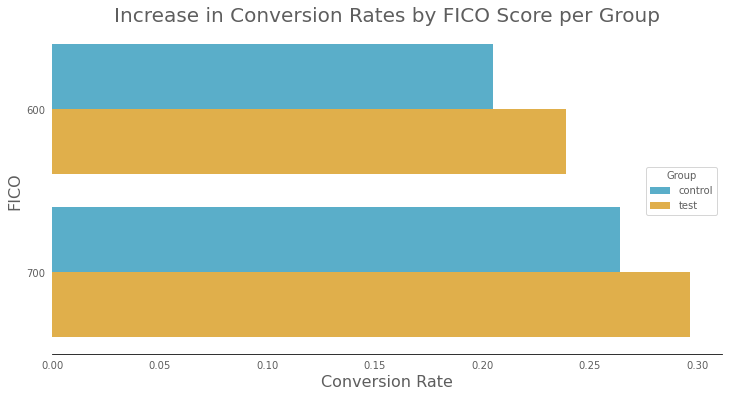

In [91]:
# plot increase in conversion rates
plt.figure(figsize=(12, 6))

sns.barplot(data = conversion, x = 'conversion_rate' , y = 'fico', hue='apr_test_group',
            palette = car_company_test_palette, orient = 'h')

plt.title("Increase in Conversion Rates by FICO Score per Group", fontsize=20)
plt.xlabel("Conversion Rate", fontsize=16)
plt.ylabel("FICO", fontsize=16)
plt.legend(loc='center right', title='Group')
plt.tick_params(left=False,bottom=False,labelleft=True,labelbottom=True)

plt.show()

In [92]:
# print increase in conversion rates
inc_600 =  round(((conversion[conversion['fico'] == 600]['conversion_rate'][2] / conversion[conversion['fico'] == 600]['conversion_rate'][0]) - 1 )* 100, 2)
inc_700 =  round(((conversion[conversion['fico'] == 700]['conversion_rate'][3] / conversion[conversion['fico'] == 700]['conversion_rate'][1]) - 1 )* 100, 2)
inc_group =  round(((group_conversion['conversion_rate'][1] / group_conversion['conversion_rate'][0]) - 1 )* 100, 2)

print('The conversion rate saw an increase of +', inc_600,'% for customers with a 600 FICO score')
print('The conversion rate saw an increase of +', inc_700,'% for customers with a 700 FICO score')
print('The conversion rate saw an increase of +', inc_group,'% for customers overall')

The conversion rate saw an increase of + 16.59 % for customers with a 600 FICO score
The conversion rate saw an increase of + 12.41 % for customers with a 700 FICO score
The conversion rate saw an increase of + 14.69 % for customers overall


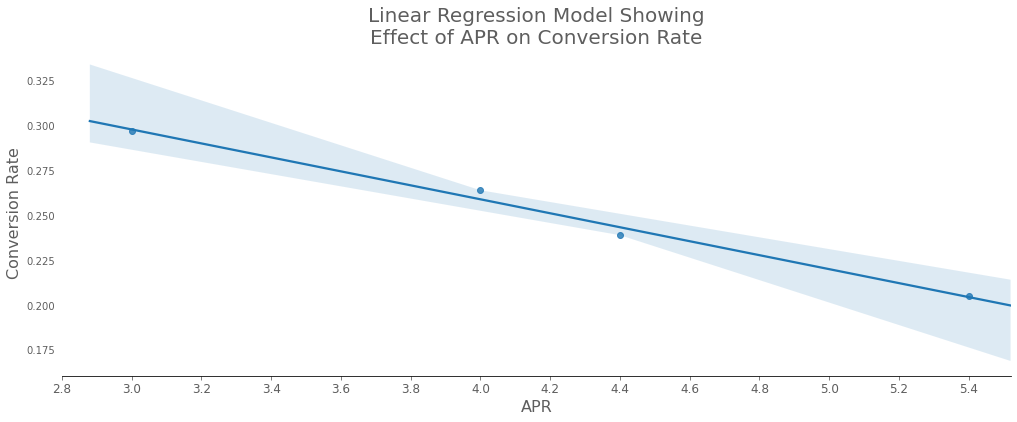

In [93]:
# plot lm for apr and conversion rates
plt.figure(figsize=(17,6))

sns.regplot(x='apr', y="conversion_rate", data=conversion, truncate = False)

plt.title("Linear Regression Model Showing\nEffect of APR on Conversion Rate", fontsize=20)
plt.xlabel("APR", fontsize=16)
plt.ylabel("Conversion Rate", fontsize=16)
plt.xticks(ticks = np.arange(2.8, 5.6, 0.2) , size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

plt.show()

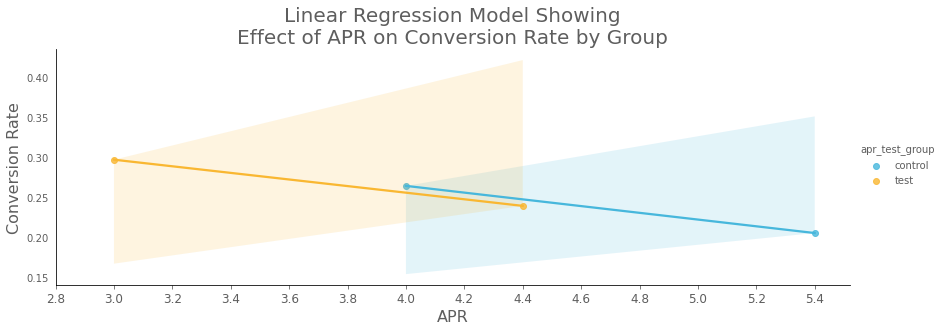

In [94]:
# plot lm for apr and conversion rates by test group
sns.lmplot(x='apr', y="conversion_rate", hue="apr_test_group", data=conversion, height = 4, aspect = 3, 
           palette = car_company_test_palette)

plt.title("Linear Regression Model Showing\nEffect of APR on Conversion Rate by Group", fontsize=20)
plt.xlabel("APR", fontsize=16)
plt.ylabel("Conversion Rate", fontsize=16)
plt.xticks(ticks = np.arange(2.8, 5.6, 0.2) , size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

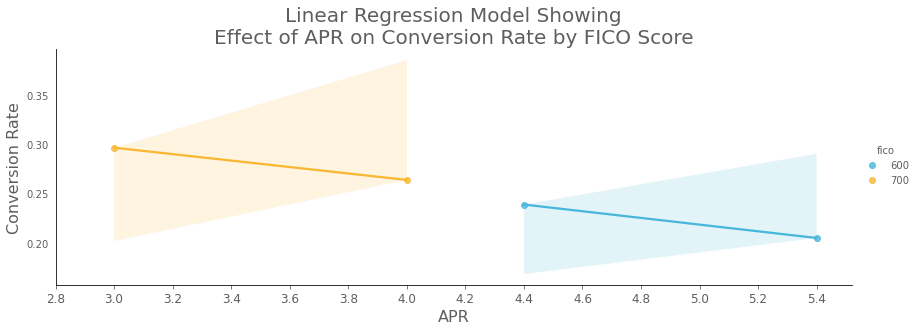

In [95]:
# plot lm for apr and conversion rates by fico score
sns.lmplot(x='apr', y="conversion_rate", hue="fico", data=conversion, height = 4, aspect = 3, 
           palette = car_company_fico_palette)

plt.title("Linear Regression Model Showing\nEffect of APR on Conversion Rate by FICO Score", fontsize=20)
plt.xlabel("APR", fontsize=16)
plt.ylabel("Conversion Rate", fontsize=16)
plt.xticks(ticks = np.arange(2.8, 5.6, 0.2) , size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

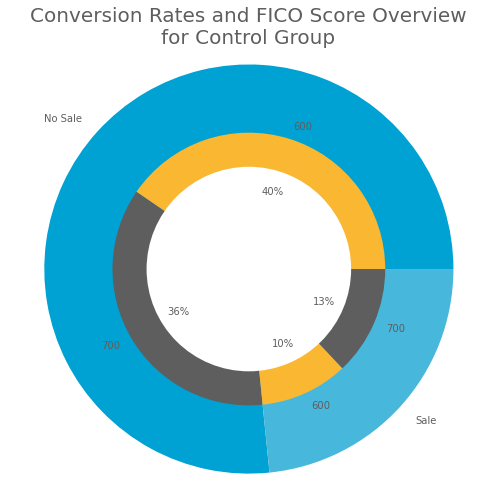

In [96]:
# plot control conversion rate overview
fig = plt.figure(figsize=(7, 7))

plt.title('Conversion Rates and FICO Score Overview\nfor Control Group', fontsize=20)

labels = ['No Sale','Sale']
sizes = control['converted to sale'].value_counts().tolist()

labels_pass = ['600', '700', '600', '700']

sizes_pass = np.concatenate([[control[(control['converted to sale']==False) & (control['fico']==600)].count().unique()[0]], 
        [control[(control['converted to sale']==False) & (control['fico']==700)].count().unique()[0]],
        control[(control['converted to sale']==True) & (control['fico']==600)].count().unique().tolist(), 
        control[(control['converted to sale']==True) & (control['fico']==700)].count().unique().tolist()])

colors = outer_list
colors_pass = inner_list


plt.pie(sizes, labels=labels, colors=colors, startangle=0, frame=True, radius=3)

plt.pie(sizes_pass, labels=labels_pass, colors=colors_pass, startangle=0, radius=2 ,autopct='%1.0f%%')

centre_circle = plt.Circle((0,0), 1.5, color='black', fc='white', linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.axis('equal')


plt.tight_layout()
plt.show()



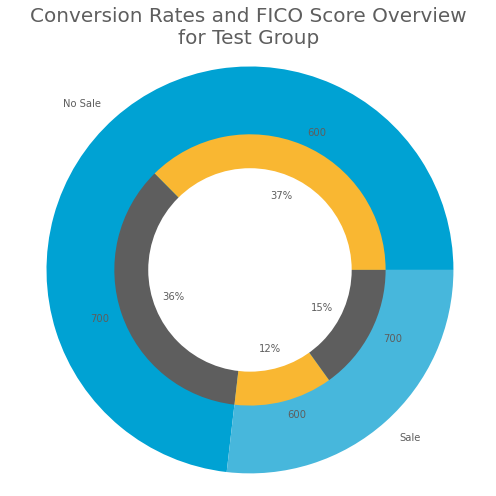

In [97]:
# plot test conversion rate overview
fig = plt.figure(figsize=(7, 7))

plt.title('Conversion Rates and FICO Score Overview\nfor Test Group', fontsize=20)

labels = ['No Sale','Sale']
sizes = test['converted to sale'].value_counts().tolist()

labels_pass = ['600', '700', '600', '700']

sizes_pass = np.concatenate([[test[(test['converted to sale']==False) & (test['fico']==600)].count().unique()[0]], 
        [test[(test['converted to sale']==False) & (test['fico']==700)].count().unique()[0]],
        test[(test['converted to sale']==True) & (test['fico']==600)].count().unique().tolist(), 
        test[(test['converted to sale']==True) & (test['fico']==700)].count().unique().tolist()])

colors = outer_list
colors_pass = inner_list


plt.pie(sizes, labels=labels, colors=colors, startangle=0, frame=True, radius=3)

plt.pie(sizes_pass, labels=labels_pass, colors=colors_pass, startangle=0, radius=2 ,autopct='%1.0f%%')

centre_circle = plt.Circle((0,0), 1.5, color='black', fc='white', linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.axis('equal')


plt.tight_layout()
plt.show()



In [98]:
# subset df
margin = summary[['apr_test_group', 'fico', 'apr','total_apps','num_sales','vehicle margin', 'finance margin', 
                  'total_margin', 'total_margin_per_sale','vehicle_margin_per_sale', 'finance_margin_per_sale',
                  'total_margin_per_app', 'vehicle_margin_per_app', 'finance_margin_per_app']].copy()
margin

,apr_test_group,fico,apr,total_apps,num_sales,vehicle margin,finance margin,total_margin,total_margin_per_sale,vehicle_margin_per_sale,finance_margin_per_sale,total_margin_per_app,vehicle_margin_per_app,finance_margin_per_app
0,control,600,5.4,5095,1044,1044000.0,678600.0,1722600.0,1650.0,1000.0,650.0,338.09617272,204.90677134,133.18940137
1,control,700,4.0,4926,1300,1300000.0,780000.0,2080000.0,1600.0,1000.0,600.0,422.24928948,263.90580593,158.34348356
2,test,600,4.4,4906,1172,1172000.0,468800.0,1640800.0,1400.0,1000.0,400.0,334.44761517,238.89115369,95.55646148
3,test,700,3.0,5073,1505,1505000.0,526750.0,2031750.0,1350.0,1000.0,350.0,400.50266115,296.66863789,103.83402326


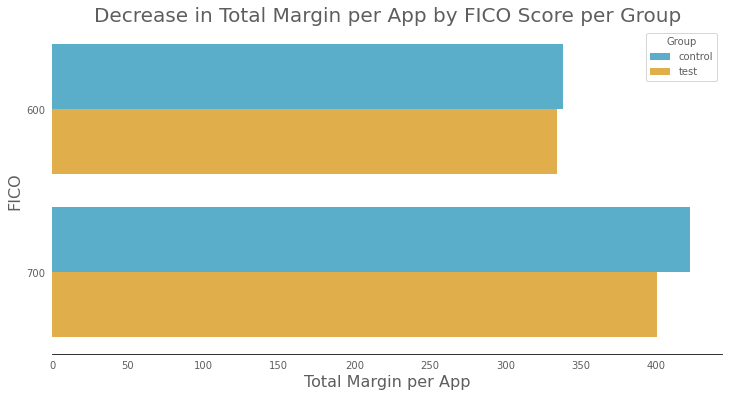

In [99]:
# plot decrease in total margin per app
plt.figure(figsize=(12, 6))

sns.barplot(data = margin, x = 'total_margin_per_app' , y = 'fico', hue='apr_test_group',
            palette = car_company_test_palette, orient = 'h')

plt.title("Decrease in Total Margin per App by FICO Score per Group", fontsize=20)
plt.xlabel("Total Margin per App", fontsize=16)
plt.ylabel("FICO", fontsize=16)
plt.legend(loc='upper right', title='Group')
plt.tick_params(left=False,bottom=False,labelleft=True,labelbottom=True)

plt.show()

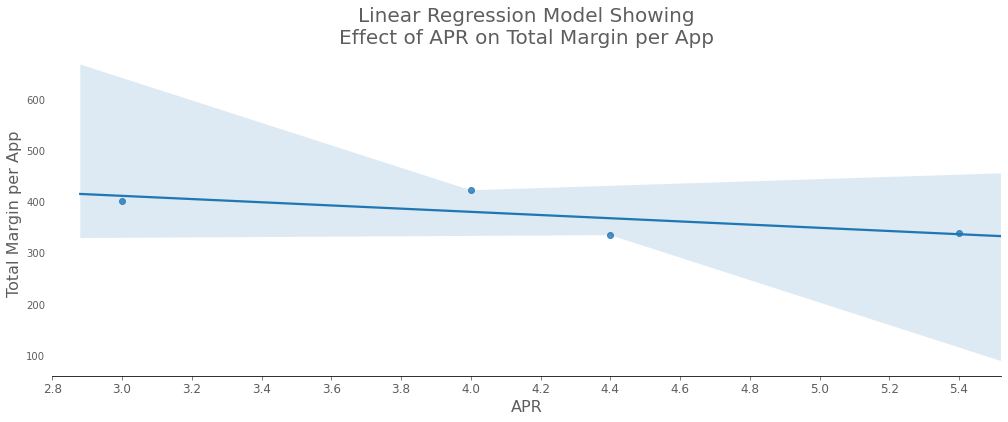

In [100]:
# plot lm trend of apr on total margin per app
plt.figure(figsize=(17,6))

sns.regplot(x='apr', y="total_margin_per_app", data=margin, truncate = False)

plt.title("Linear Regression Model Showing\nEffect of APR on Total Margin per App", fontsize=20)
plt.xlabel("APR", fontsize=16)
plt.ylabel("Total Margin per App", fontsize=16)
plt.xticks(ticks = np.arange(2.8, 5.6, 0.2) , size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

plt.show()

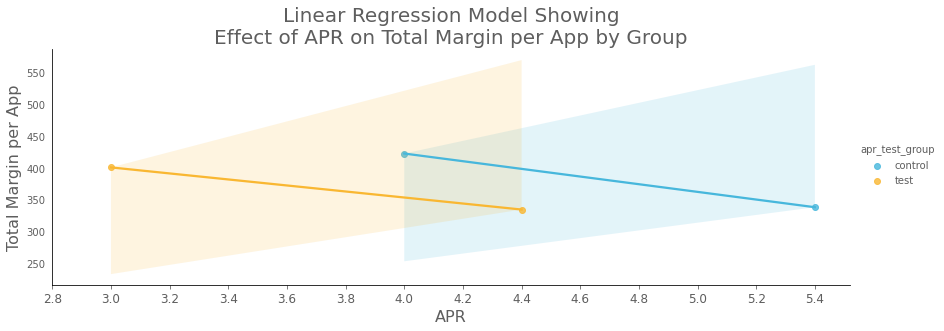

In [101]:
# plot lm for apr and total margin per app by test group
sns.lmplot(x='apr', y="total_margin_per_app", hue="apr_test_group", data=margin, height = 4, aspect = 3, 
           palette = car_company_test_palette)

plt.title("Linear Regression Model Showing\nEffect of APR on Total Margin per App by Group", fontsize=20)
plt.xlabel("APR", fontsize=16)
plt.ylabel("Total Margin per App", fontsize=16)
plt.xticks(ticks = np.arange(2.8, 5.6, 0.2) , size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

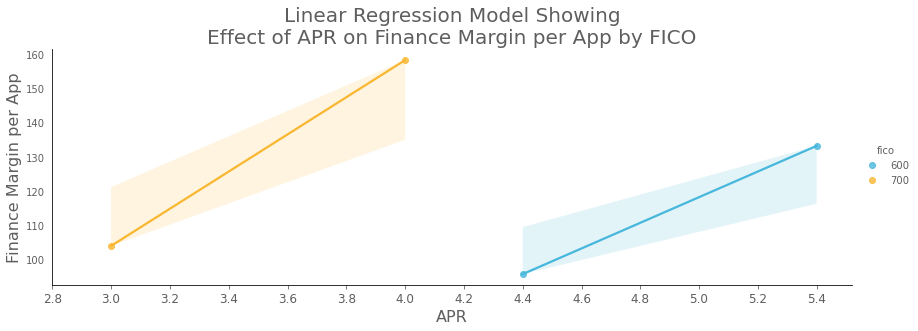

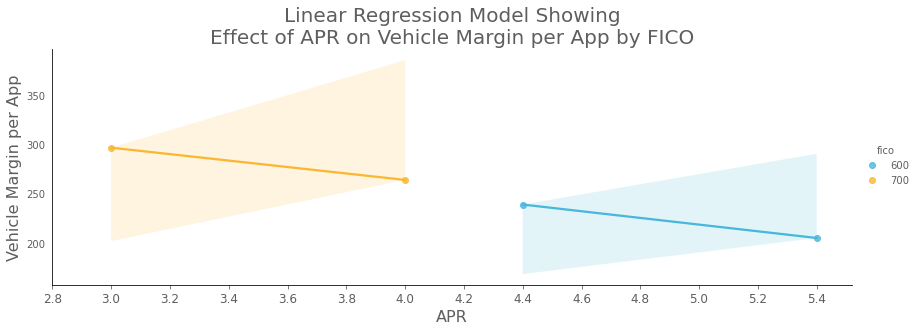

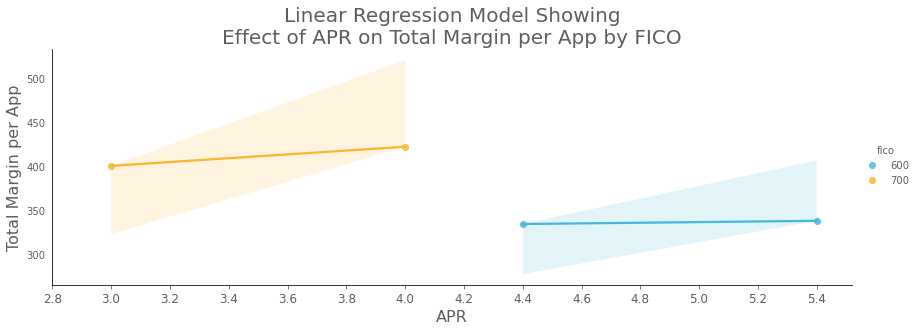

In [102]:
# lm plots for apr and finance margin per app by fico
sns.lmplot(x='apr', y="finance_margin_per_app", hue="fico", data=margin, height = 4, aspect = 3, 
           palette = car_company_fico_palette, truncate = True)

plt.title("Linear Regression Model Showing\nEffect of APR on Finance Margin per App by FICO", fontsize=20)
plt.xlabel("APR", fontsize=16)
plt.ylabel("Finance Margin per App", fontsize=16)
plt.xticks(ticks = np.arange(2.8, 5.6, 0.2) , size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

sns.lmplot(x='apr', y="vehicle_margin_per_app", hue="fico", data=margin, height = 4, aspect = 3, 
           palette = car_company_fico_palette, truncate = True)

plt.title("Linear Regression Model Showing\nEffect of APR on Vehicle Margin per App by FICO", fontsize=20)
plt.xlabel("APR", fontsize=16)
plt.ylabel("Vehicle Margin per App", fontsize=16)
plt.xticks(ticks = np.arange(2.8, 5.6, 0.2) , size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

sns.lmplot(x='apr', y="total_margin_per_app", hue="fico", data=margin, height = 4, aspect = 3, 
           palette = car_company_fico_palette, truncate = True)

plt.title("Linear Regression Model Showing\nEffect of APR on Total Margin per App by FICO", fontsize=20)
plt.xlabel("APR", fontsize=16)
plt.ylabel("Total Margin per App", fontsize=16)
plt.xticks(ticks = np.arange(2.8, 5.6, 0.2) , size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

In [103]:
# subset df
big_picture = summary[['apr_test_group', 'fico', 'apr' , 'total_margin', 'vehicle margin', 
                       'finance margin', 'total_margin_per_app']].copy()
big_picture

,apr_test_group,fico,apr,total_margin,vehicle margin,finance margin,total_margin_per_app
0,control,600,5.4,1722600.0,1044000.0,678600.0,338.09617272
1,control,700,4.0,2080000.0,1300000.0,780000.0,422.24928948
2,test,600,4.4,1640800.0,1172000.0,468800.0,334.44761517
3,test,700,3.0,2031750.0,1505000.0,526750.0,400.50266115


In [104]:
# get data ready to graph
big_picture_600 = big_picture[big_picture['fico']==600]
bars1 = list(big_picture_600['total_margin'])
bars2 = list(big_picture_600['vehicle margin'])
bars3 = list(big_picture_600['finance margin'])
bars = (bars1 + bars2 + bars3)
names = ['Total Margin\nControl', 'Total Margin\nTest', 'Vehicle Margin\nControl', 'Vehicle Margin\nTest',
         'Finance Margin\nControl', 'Finance Margin\nTest']
big_600 = pd.DataFrame(zip(bars, names), columns =['bars', 'names'])

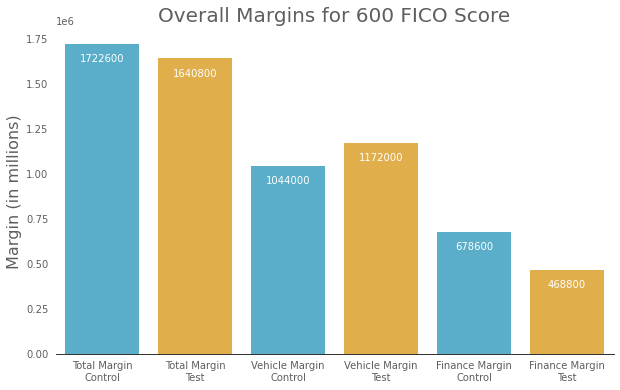

In [105]:
# plot total margins for 600 fico group
plt.figure(figsize=(10, 6))

b6 = sns.barplot(data= big_600, x='names', y = 'bars',palette = car_company_list, dodge=False)

plt.title("Overall Margins for 600 FICO Score", fontsize=20)
plt.xlabel("", fontsize=16)
plt.ylabel("Margin (in millions)", fontsize=16)
plt.tick_params(left=False,bottom=False,labelleft=True,labelbottom=True)

for index, row in big_600[['bars']].iterrows():
    b6.text(row.name, row.bars-100000, round(row.bars), color='white', ha="center", fontsize=10)

plt.show()

In [106]:
# get data ready to graph
big_picture_700 = big_picture[big_picture['fico']==700]
bars1 = list(big_picture_700['total_margin'])
bars2 = list(big_picture_700['vehicle margin'])
bars3 = list(big_picture_700['finance margin'])
bars = (bars1 + bars2 + bars3)
names = ['Total Margin\nControl', 'Total Margin\nTest', 'Vehicle Margin\nControl', 'Vehicle Margin\nTest',
         'Finance Margin\nControl', 'Finance Margin\nTest']
big_700 = pd.DataFrame(zip(bars, names), columns =['bars', 'names'])


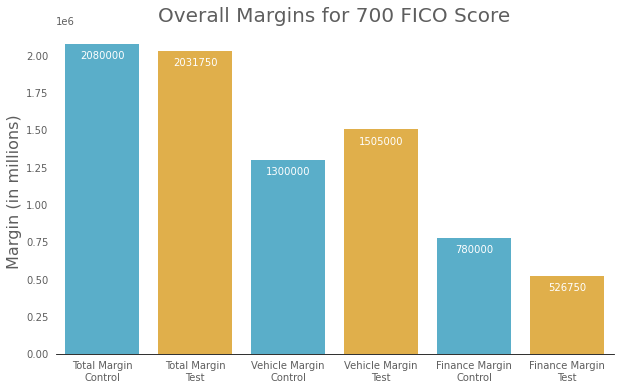

In [107]:
# plot total margins for 700 fico group
plt.figure(figsize=(10, 6))

b7 = sns.barplot(data= big_700, x='names', y = 'bars',palette = car_company_list, dodge=False)

plt.title("Overall Margins for 700 FICO Score", fontsize=20)
plt.xlabel("", fontsize=16)
plt.ylabel("Margin (in millions)", fontsize=16)
plt.tick_params(left=False,bottom=False,labelleft=True,labelbottom=True)

for index, row in big_700[['bars']].iterrows():
    b7.text(row.name, row.bars-100000, round(row.bars), color='white', ha="center", fontsize=10)

plt.show()

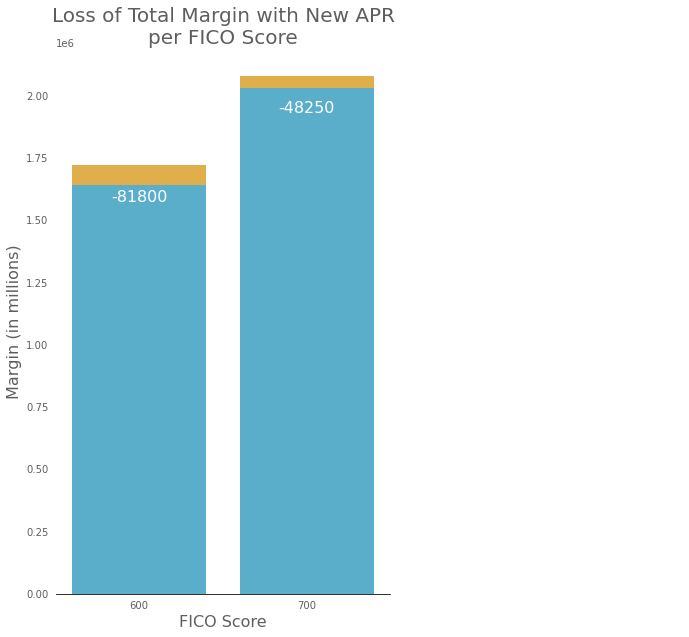

In [108]:
# plot loss for new apr #1560000
plt.figure(figsize=(6, 10))
  
loss_control = sns.barplot(x=big_picture[big_picture['apr_test_group'] == 'control']['fico'], 
                           y=big_picture[big_picture['apr_test_group'] == 'control']['total_margin'], color=car_company_gold)
loss_test = sns.barplot(x=big_picture[big_picture['apr_test_group'] == 'test']['fico'], 
                        y=big_picture[big_picture['apr_test_group'] == 'test']['total_margin'],color=car_company_lightblue)
  
plt.title("Loss of Total Margin with New APR\nper FICO Score", fontsize=20)
plt.xlabel("FICO Score", fontsize=16)
plt.ylabel("Margin (in millions)", fontsize=16)
plt.tick_params(left=False,bottom=False,labelleft=True,labelbottom=True)

row_list = []
for index, row1 in big_picture[big_picture['apr_test_group'] == 'test'][['total_margin']].iterrows():
    loss_test.text(row1.name, row1.total_margin-50, row1.total_margin, color='white', ha="center", fontsize=15)
    row_list.append(row1[0])

for index, row in big_picture[big_picture['apr_test_group'] == 'control'][['total_margin']].iterrows():
    loss_control.text(row.name, row.total_margin-150000, round(row_list[index]-row.total_margin), 
                      color='white', ha="center", fontsize=16)

plt.show()

### Projections
 


In [109]:
# subset df
projection = summary[['apr_test_group', 'fico', 'apr' , 'num_sales', 'conversion_rate', 'total_margin_per_sale']].copy()
projection

,apr_test_group,fico,apr,num_sales,conversion_rate,total_margin_per_sale
0,control,600,5.4,1044,0.20490677,1650.0
1,control,700,4.0,1300,0.26390581,1600.0
2,test,600,4.4,1172,0.23889115,1400.0
3,test,700,3.0,1505,0.29666864,1350.0


In [110]:
#append rows to the dataframe
row1 = {'apr_test_group':'projected', 'fico':600, 'apr':4.4, 'num_sales':1172, 'conversion_rate': 0.23889115, 'total_margin_per_sale': 1500}
row2 = {'apr_test_group':'projected', 'fico':700, 'apr':3.0, 'num_sales':1505, 'conversion_rate': 0.29666864, 'total_margin_per_sale': 1450}

projection = projection.append(row1, ignore_index=True).append(row2, ignore_index=True)

In [111]:
projection['expected_value'] =  projection['conversion_rate'] * projection['total_margin_per_sale']
projection['total_margin'] = projection['num_sales']* projection['total_margin_per_sale']
projection = projection.sort_values(['fico', 'apr'],ascending = [True, False]).reset_index(drop=False)
projection

,index,apr_test_group,fico,apr,num_sales,conversion_rate,total_margin_per_sale,expected_value,total_margin
0,0,control,600,5.4,1044,0.20490677,1650.0,338.09617272,1722600.0
1,2,test,600,4.4,1172,0.23889115,1400.0,334.44761517,1640800.0
2,4,projected,600,4.4,1172,0.23889115,1500.0,358.33672500,1758000.0
3,1,control,700,4.0,1300,0.26390581,1600.0,422.24928948,2080000.0
4,3,test,700,3.0,1505,0.29666864,1350.0,400.50266115,2031750.0
5,5,projected,700,3.0,1505,0.29666864,1450.0,430.16952800,2182250.0


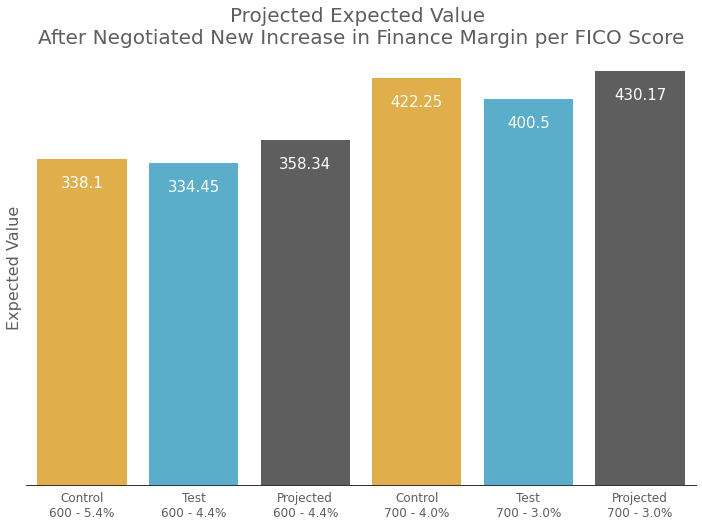

In [112]:
# plot expected value
plt.figure(figsize=(12,8))

labels = ['Control\n600 - 5.4%', 'Test\n600 - 4.4%', 'Projected\n600 - 4.4%',
          'Control\n700 - 4.0%', 'Test\n700 - 3.0%','Projected\n700 - 3.0%']

proj = sns.barplot(data=projection ,x=projection.index ,y="expected_value", palette = car_company_proj_palette)

plt.title("Projected Expected Value \nAfter Negotiated New Increase in Finance Margin per FICO Score", fontsize=20)
plt.xlabel("", fontsize=16)
plt.ylabel("Expected Value", fontsize=16)
plt.xticks(ticks = range(6) ,labels = labels, size =12)
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=True)

for index, row in projection[['expected_value']].iterrows():
    proj.text(row.name, row.expected_value-30, round(row.expected_value, 2), color='white', 
              ha="center", fontsize=15)


plt.show()

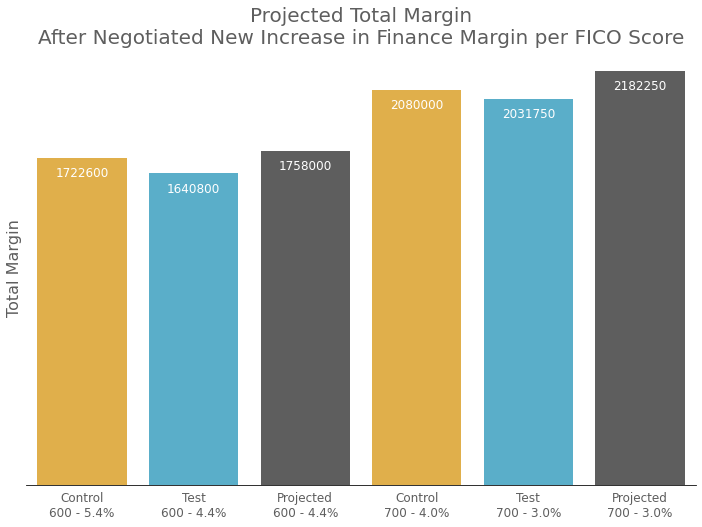

In [113]:
# plot projected margin overall
plt.figure(figsize=(12,8))


labels = ['Control\n600 - 5.4%', 'Test\n600 - 4.4%', 'Projected\n600 - 4.4%',
          'Control\n700 - 4.0%', 'Test\n700 - 3.0%','Projected\n700 - 3.0%']

proj = sns.barplot(data=projection, x=projection.index, y="total_margin", 
                   palette = car_company_proj_palette)

plt.title("Projected Total Margin\nAfter Negotiated New Increase in Finance Margin per FICO Score", fontsize=20)
plt.xlabel("", fontsize=16)
plt.ylabel("Total Margin", fontsize=16)
plt.xticks(ticks = range(6) ,labels = labels, size =12)
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=True)

for index, row in projection[['total_margin']].iterrows():
    proj.text(row.name, row.total_margin-100000, round(row.total_margin), 
              color='white', ha="center", fontsize=12)


plt.show()